In [ ]:
import string
import pandas as pd
import spacy
from itertools import chain
import gensim
from gensim.models.callbacks import CallbackAny2Vec
from gensim.models.phrases import Phraser
from gensim.utils import simple_preprocess
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from gensim import corpora
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
import matplotlib.patches as mpatches
from google.colab import drive
import json
import itertools
from sklearn.feature_extraction import text

In [ ]:
dataset = pd.read_json("News_Category_Dataset_v2.json", lines=True, dtype={"headline": str})

In [ ]:
dataset.head()

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


In [ ]:
#@title Function identifying words in a sentence in a really dummy way
def dummy_word_split(texts):
    """Function identifying words in a sentence in a really dummy way.

        Argument:
            - texts (list of str): a list of raw texts in which we'd like to identify words

        Return:
            - list of list containing each word separately.
    """
    texts_out = []
    for text in texts:
        texts_out.append(text.split(" "))

    return texts_out

splitted_texts = dummy_word_split(dataset["headline"].tolist()) # on parcourt toute les headlines on sépare chaque mot par ""

In [ ]:
#@title Compute word ooccurences
def compute_word_occurences(texts):
    words = itertools.chain.from_iterable(texts) # unlist nested list

    word_count = pd.Series(words).value_counts() # count word occurences
    word_count = pd.DataFrame({"Word": word_count.index, "Count": word_count.values}) # create DataFrame

    return word_count
res = compute_word_occurences(splitted_texts)

In [ ]:
#@title Get stopwords
def get_stopwords(additional_stopwords=[]):
    """Return a list of english stopwords, that can be augmented by using a stopwords file or a list of stopwords

    Args:
        filepath (str, optional): path to a text file where each line is a stopword
        additional_stopwords (list of str, optional): list of string representing stopwords
    Returns:
        List of strings representing stopwords
    """
    # Loading standard english stop words
    with open('stopwords.txt', 'r') as f:
        stop_w = f.readlines() # return a list stop_w where each line of the file correspond to an element of the list
    stopwords = [s.rstrip() for s in stop_w] # removing trailing new line "\n" character

    # Adding stop words from sklearn
    stopwords = list(text.ENGLISH_STOP_WORDS.union(stopwords))

    # Adding words from a list if specified
    if additional_stopwords:
        stopwords += additional_stopwords

    # Removing duplicates
    stopwords = list(set(stopwords))

    # Removing some \n that were included in the native stopwords of sklearn ... WHY?
    stopwords = [s.replace("\n", "") for s in stopwords]

    stopwords = sorted(stopwords, key=str.lower)

    return stopwords
stopwords = get_stopwords()

# Analyse Préliminaire du Corpus

## Nombre moyen de mots par titre

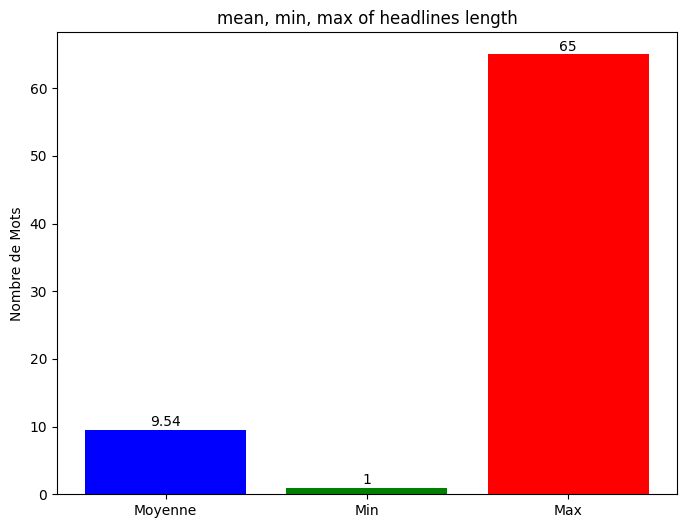

In [ ]:
# Calcul des longueurs des titres
word_count_by_headline = [len(headline) for headline in splitted_texts]

# Calcul des statistiques
mean_length = np.mean(word_count_by_headline)
min_length = np.min(word_count_by_headline)
max_length = np.max(word_count_by_headline)

# Création du graphique en barres
labels = ['Moyenne', 'Min', 'Max']
values = [mean_length, min_length, max_length]

plt.figure(figsize=(8, 6))
bars = plt.bar(labels, values, color=['blue', 'green', 'red'])
plt.title('mean, min, max of headlines length')
plt.ylabel('Nombre de Mots')

# Adding labels to the bars
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5, str(round(value, 2)), ha='center')

plt.show()

La longueur moyenne des titres est de 9.54 mots. Cela suggère que les titres sont généralement concis et vont droit au but, ce qui est typique des titres de journaux qui doivent capturer l'attention rapidement.


La longueur minimale des titres est de 1 mot, ce qui est très inhabituel et pourrait être le résultat d'une erreur de données. Un tel titre ne donnerait pas beaucoup d'informations sur le contenu de l'article.


La longueur maximale est de 65 mots, ce qui est exceptionnellement long et suggère un titre très descriptif ou peut-être un titre incluant une citation ou un sous-titre.

Globalement, les titres plus courts pourraient ne pas fournir suffisamment de contexte pour un clustering significatif, tandis que des titres extrêmement longs pourraient biaiser l'analyse en donnant trop de poids à certains articles. C'est un point important à considérer avant d'appliquer une méthode de Topic Modeling

## Distribution des taille de titres

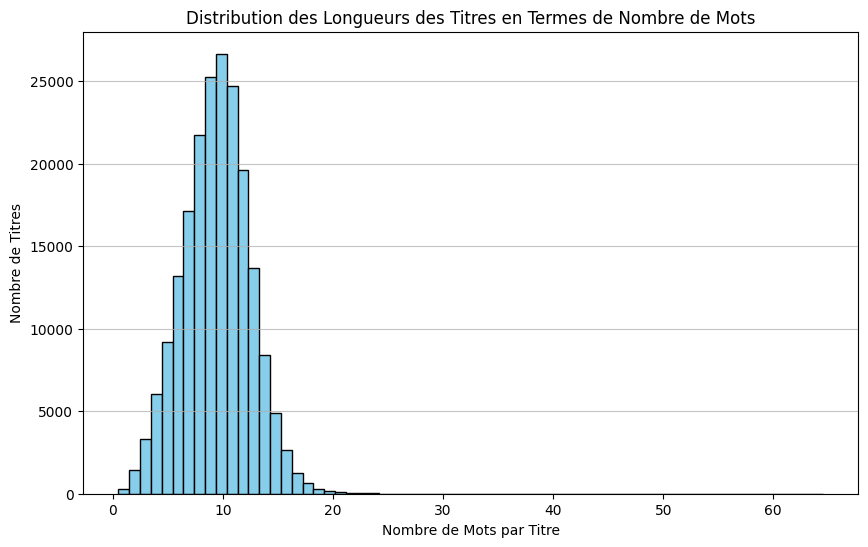

In [ ]:
# Calcul du nombre de mots par titre
word_count_by_headline = [len(headline) for headline in splitted_texts]

# Distribution des Longueurs des Titres en Termes de Nombre de Mots
plt.figure(figsize=(10, 6))
plt.hist(word_count_by_headline, bins=max(word_count_by_headline), align='left', color='skyblue', edgecolor='black')
plt.xlabel('Nombre de Mots par Titre')
plt.ylabel('Nombre de Titres')
plt.title('Distribution des Longueurs des Titres en Termes de Nombre de Mots')
plt.grid(axis='y', alpha=0.75)
plt.show()

Approximativement, la distribution semble suivre une distribution normale centrée autour de sa moyenne avec la majorité des titres ayant une longueur qui se situe dans une gamme étroite de mots.

La distribution montre également que les titres extrêmement courts et extrêmement longs sont rares, ce qui est cohérent dans le sens où les titres doivent être assez informatifs tout en restant succincts pour une lecture facile et rapide.

Pour les applications de topic modeling ou de clustering, cette distribution indique que la longueur des titres ne varie pas de manière significative, ce qui pourrait aider à maintenir une certaine uniformité dans l'analyse textuelle.

## mots les plus fréquents

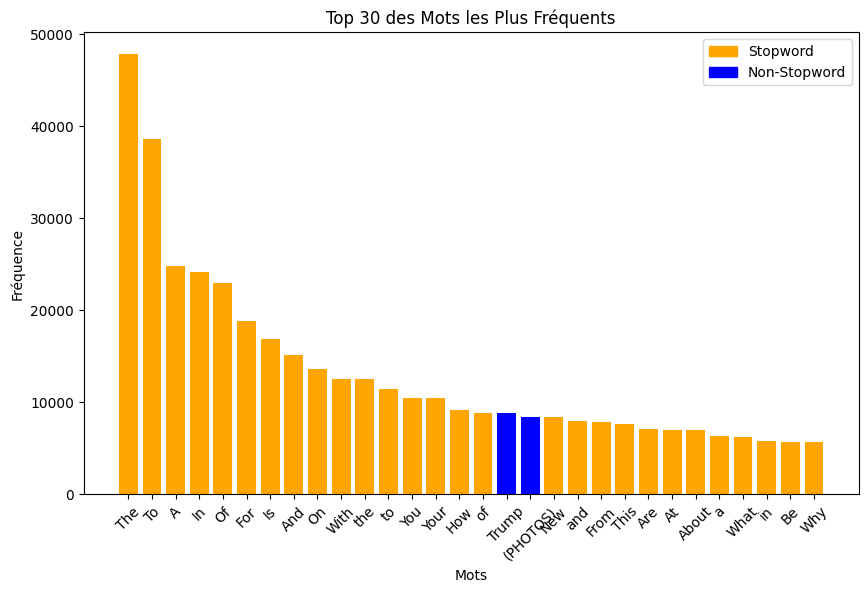

In [ ]:
top_words = res.head(30)

# Création de la liste de couleurs
colors = ['orange' if word.lower() in stopwords else 'blue' for word in res['Word'].head(30)]

# Création du diagramme à barres
plt.figure(figsize=(10, 6))
plt.bar(top_words['Word'], top_words['Count'], color=colors)

# Création de légendes pour les couleurs
stopword_patch = mpatches.Patch(color='orange', label='Stopword')
non_stopword_patch = mpatches.Patch(color='blue', label='Non-Stopword')
plt.legend(handles=[stopword_patch, non_stopword_patch])

# Personnalisation du diagramme
plt.xlabel('Mots')
plt.ylabel('Fréquence')
plt.title('Top 30 des Mots les Plus Fréquents')
plt.xticks(rotation=45)  # Incliner les étiquettes pour une meilleure lisibilité

# Affichage du diagramme
plt.show()


Les trente mots les plus fréquents dans notre corpus de textes sont majoritairement composés de stopwords, ce qui pose problème car ils n'apportent aucune information pertinente sur le sujet de l'article.

Parmi les mots non-stopwords, seulement deux se distinguent dans ce top, comme "Trump" qui pourrait potentiellement indiquer des sujets politiques ou des informations concernant cette figure politique. Cependant, il n'informe pas directement sur la thématique précise abordée par l'article. Quant au terme "(PHOTOS)", il est complètement non informatif puisque sa présence relève d'une mention de contenus visuels associés aux articles.

Cela confirme donc l'importance d'une étape de nettoyage préalable, qui inclurait le filtrage des stopwords et d'autres termes peu informatifs. Ce traitement permettrait de dégager plus clairement les sujets de fond du corpus et d'obtenir des résultats de topic modeling plus précis et pertinents

### Word Cloud

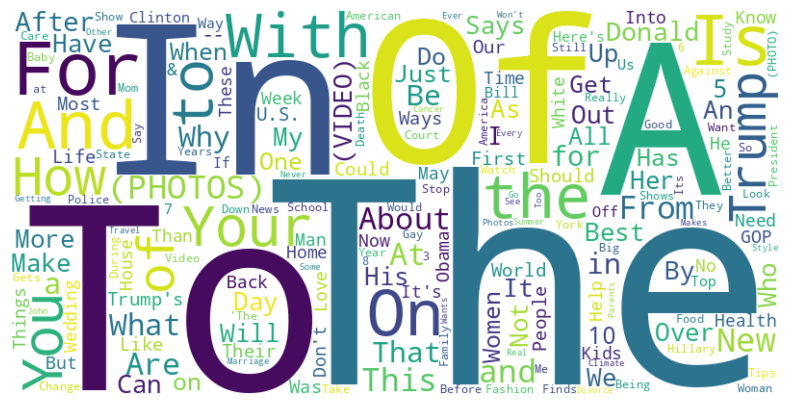

In [ ]:
# Calculer les fréquences des mots
all_words = [word for sublist in splitted_texts for word in sublist]
word_frequencies = Counter(all_words)

# Création du Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color ='white', random_state=1).generate_from_frequencies(word_frequencies)

# Affichage du Word Cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Le Word Cloud est une visualisation intéressante, car elle met en évidence la fréquence des mots, confirmant ainsi les observations précédentes. Elle permet également de se rendre compte de la présence de "doublons" tels que "and" et "And", indiquant que le corpus pourrait bénéficier d'une normalisation de la casse, ce qui consoliderait leurs fréquences réelles.

### stopwords

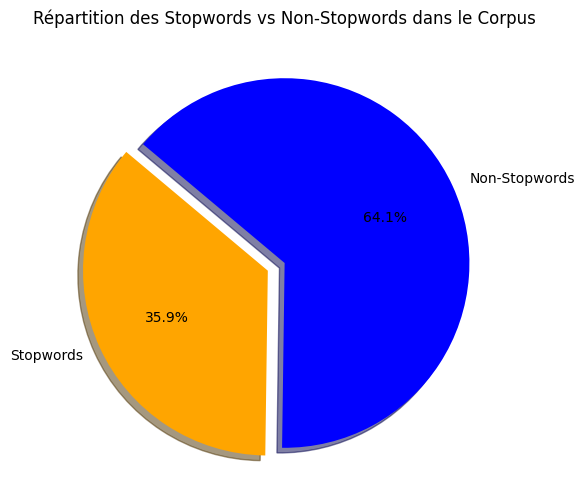

In [ ]:
all_words_ = [word.lower() for sublist in splitted_texts for word in sublist]  # Convertir en minuscules pour la cohérence

# Compter les occurrences de chaque mot
word_counts = Counter(all_words_)

# Compter les stopwords
stopword_count = sum(word_counts[word] for word in word_counts.keys() if word in stopwords)

# Part des stop words dans le corpus total en %
non_stopword_count = len(all_words) - stopword_count

# Données pour le diagramme à secteurs
labels = ['Stopwords', 'Non-Stopwords']
sizes = [stopword_count, non_stopword_count]
colors = ['orange', 'blue']
explode = (0.1, 0)  # Pour faire ressortir le segment des stopwords

# Création du diagramme à secteurs
plt.figure(figsize=(6, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Répartition des Stopwords vs Non-Stopwords dans le Corpus')

# Affichage du diagramme
plt.show()

35.9% des mots sont classés comme stopwords et les 64.1% restants sont des non-stopwords. Ces derniers constituent la partie du corpus qui nous intéresse pour l'application d'un modèle de topic modeling. Cependant, même parmi ces 64.1%, certains ne sont pas pertinents pour déterminer des topics.  

# Analyse du corpus après pipeline

Nous chargeons les 1000 premiers titres de journaux après lemmatisation, conformément à la pipeline mise en place précédemment, en utilisant le modèle SpaCy en_core_web_lg et en filtrant les types de mots 'NOUN', 'ADJ', 'VERB', 'ADV', et 'PROPN'. De plus, nous avons ajouté "trump", "(PHOTOS)", et "donald" à la liste des stopwords.

In [ ]:
with open('l_texts_en_core_web_lg.json', 'r') as file:
    l_texts = json.load(file)

## Nombre moyen de mots par titre

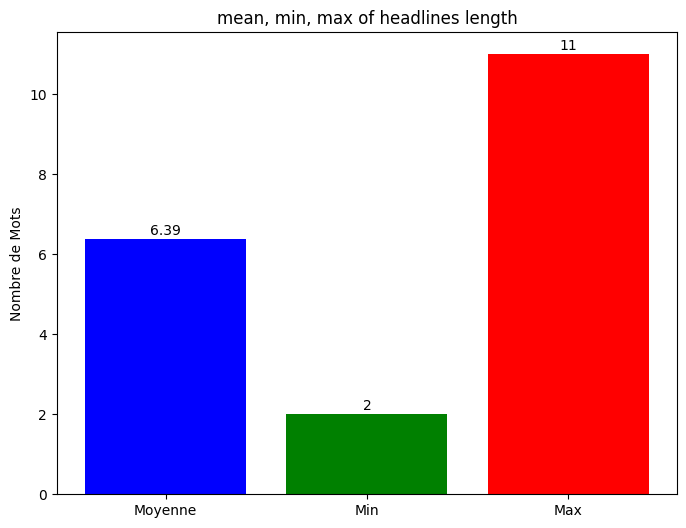

In [ ]:
# Calcul des longueurs des titres
word_count_by_headline2 = [len(headline) for headline in l_texts]

# Calcul des statistiques
mean_length2 = np.mean(word_count_by_headline2)
min_length2 = np.min(word_count_by_headline2)
max_length2 = np.max(word_count_by_headline2)

# Création du graphique en barres
labels = ['Moyenne', 'Min', 'Max']
values = [mean_length2, min_length2, max_length2]

plt.figure(figsize=(8, 6))
bars = plt.bar(labels, values, color=['blue', 'green', 'red'])
plt.title('mean, min, max of headlines length')
plt.ylabel('Nombre de Mots')

# Adding labels to the bars
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.1, str(round(value, 2)), ha='center')

plt.show()

les statistiques sont les suivantes:

Une longueur moyenne de titre de 6.39 mots.  
La longueur minimale d'un titre est de 2 mots.  
La longueur maximale d'un titre est de 11 mots.  

Par rapport aux résultats précédents qui indiquaient une moyenne plus élevée, une longueur minimale d'un mot et une longueur maximale nettement plus importante, il est évident que le processus de lemmatisation et l'élimination des mots non pertinents ont réduit la variabilité et la longueur des titres. Cette réduction des extrêmes suggère que les titres les plus longs contenaient probablement un nombre plus important de stopwords ou des termes spécifiques qui ont été éliminés. La moyenne plus faible reflète une concentration sur les mots qui portent du sens et qui sont donc plus susceptibles de contribuer à des topics significatifs.

## Distribution des taille de titres

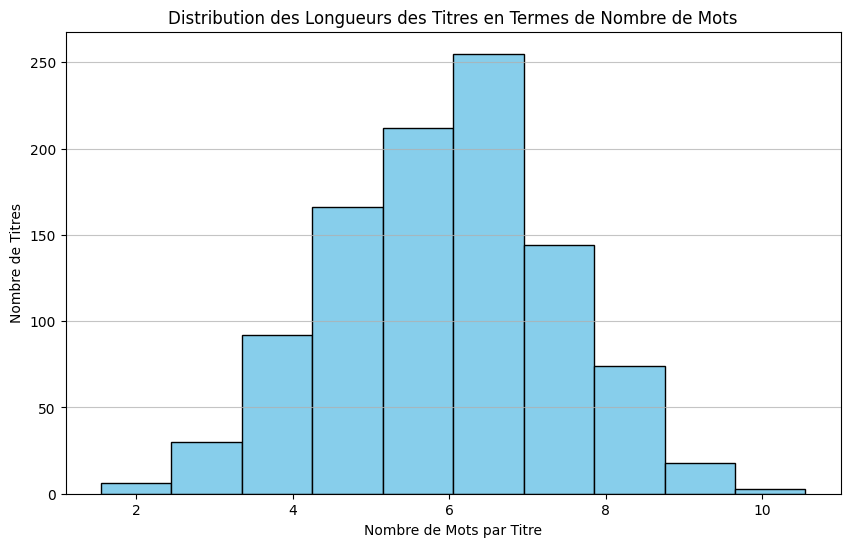

In [ ]:
# Calcul du nombre de mots par titre
word_count_by_headline2 = [len(headline) for headline in l_texts]

# Distribution des Longueurs des Titres en Termes de Nombre de Mots
plt.figure(figsize=(10, 6))
plt.hist(word_count_by_headline2, bins=10, align='left', color='skyblue', edgecolor='black')
plt.xlabel('Nombre de Mots par Titre')
plt.ylabel('Nombre de Titres')
plt.title('Distribution des Longueurs des Titres en Termes de Nombre de Mots')
plt.grid(axis='y', alpha=0.75)
plt.show()

La forme de la distribution n'a pas beaucoup été impactée par le pré-traitement des données, on retrouve à peu près une distribution normale. Cependant, cette fois-ci, le bruit a été éliminé et la longueur des titres reflète beaucoup mieux leur capacité à véhiculer des informations pertinentes.

## mots les plus fréquents

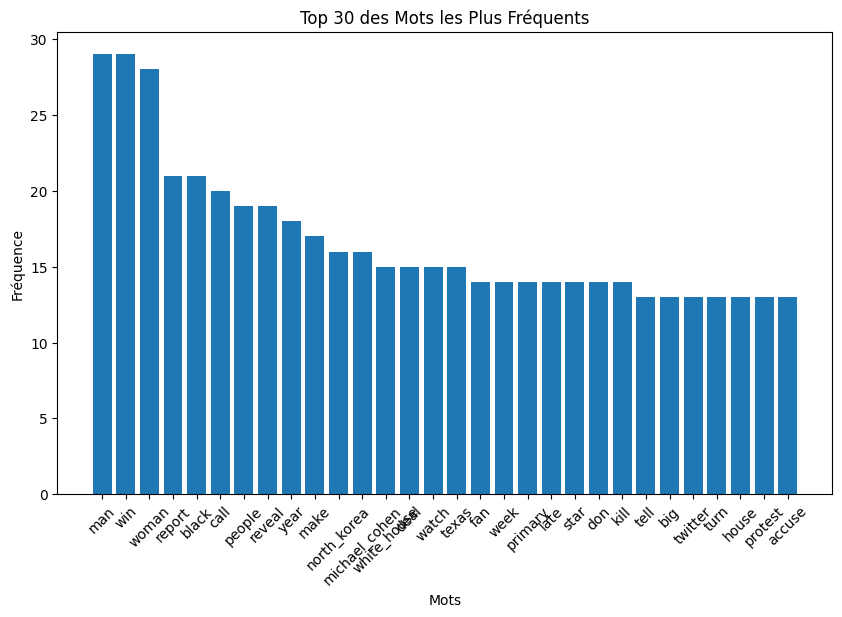

In [ ]:
res2 = compute_word_occurences(l_texts)
top_words2 = res2.head(30)

# Création du diagramme à barres
plt.figure(figsize=(10, 6))
plt.bar(top_words2['Word'], top_words2['Count'])

# Personnalisation du diagramme
plt.xlabel('Mots')
plt.ylabel('Fréquence')
plt.title('Top 30 des Mots les Plus Fréquents')
plt.xticks(rotation=45)  # Incliner les étiquettes pour une meilleure lisibilité

# Affichage du diagramme
plt.show()

Contrairement aux résultats préliminaires où des stopwords tels que "the", "is", et "and" prédominaient, la liste actuelle met en avant des mots tels que "North Korea", "report", et "kill", qui offrent plus d'indications sur les contenus spécifiques des articles.

## Wordcloud

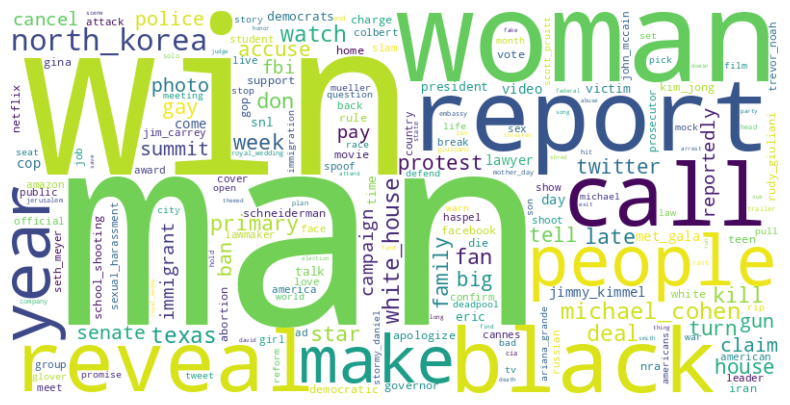

In [ ]:
# Calculer les fréquences des mots
all_words2 = [word for sublist in l_texts for word in sublist]
word_frequencies2 = Counter(all_words2)

# Création du Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color ='white', random_state=1).generate_from_frequencies(word_frequencies2)

# Affichage du Word Cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [ ]:
# Taille du vocabulaire
print("Taille du vocabulaire avant pipeline", len(set(all_words)))
print("Taille du vocabulaire après pipeline:", len(set(all_words2)))

Taille du vocabulaire avant pipeline 119589
Taille du vocabulaire après pipeline: 3045


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


La taille du vocabulaire a considérablement diminué, passant de 120K mots distincts avant la pipeline à 3K mots après la pipeline soit une réduction de 97%. Cette réduction simplifie l'analyse et accélère le processus, tout en conservant une diversité suffisante pour permettre l'identification des différents topics sous-jacents.

# Selection des 2 méthodologies de Topic Modeling / Clustering

## 1. Latent Dirichlet Allocation (LDA)

Première option :  
Tout d'abord, le LDA montre une grande efficacité dans l'identification de sujets sous-jacents dans des documents succincts comme les titres de journaux. La nature de ces titres est particulière car bien qu'ils soient composés de peu de mots, ils sont densément chargés d'informations.
En effet par nature, chaque mot dans un titre de journal est choisi pour sa capacité à véhiculer un maximum d'informations dans un espace restreint.
Le LDA excelle dans l'exploitation de ces indices, en décomposant les titres en leurs composantes thématiques.  

Ensuite, la diversité des sujets dans notre corpus de données est un avantage pour le LDA.  
Notre ensemble de données englobe une large gamme de thèmes, cette diversité est bénéfique pour le LDA car elle facilite l'identification de modèles et de relations entre les mots.  
Un titre sur le sport, par exemple, utilisera un ensemble de mots différent de celui d'un titre sur la politique, permettant au LDA de classifier et de regrouper ces titres en fonction de leurs sujets inhérents.

Enfin, avec un vocabulaire de 3045 mots distincts, le LDA dispose suffisamment de données à analyser. Ce large vocabulaire permet au LDA d'identifier des motifs de mots spécifiques et significatifs qui caractérisent chaque sujet.

### 1. Préparation des données

In [ ]:
import gensim
from gensim import corpora
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel


# Création d'un dictionnaire
dictionary = corpora.Dictionary(l_texts)

# Création du corpus (sac de mots)
corpus = [dictionary.doc2bow(text) for text in l_texts]

### 2. Entraînement du modèle LDA

In [ ]:
lda_model = LdaModel(corpus, num_topics=10, id2word=dictionary, passes=15, random_state=42)

### 3. Évaluation du modèle

Choix de la première métrique: **le score de cohérence**.  
C'est choix pertinent pour mesurer la performance de notre modèle LDA, car elle évalue la qualité des topics générés. La cohérence des topics indique à quel point les mots au sein de chaque topic sont sémantiquement liés et pertinents les uns par rapport aux autres. Une cohérence élevée signifie que les mots dans un topic sont étroitement liés et que le topic est plus informatif et interprétable.

In [ ]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=l_texts, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.6614428265696086


Le score de cohérence est de 0.6614 pour notre modèle LDA, ce qui indique que les topics générés sont raisonnablement cohérents. Ce niveau de cohérence suggère que les mots clés au sein de chaque topic sont relativement bien reliés les uns aux autres, formant des groupes de mots qui contribuent à des thèmes clairs et compréhensibles.

In [ ]:
# Calcul de la perplexité
log_perplexity = lda_model.log_perplexity(corpus)
# Convertir la log-perplexité en perplexité
print('Perplexité:', log_perplexity)

Perplexité: -8.816418891689818


Choix de la deuxième métrique: la **log-perplexité**  
C'est une mesure utilisée pour évaluer la performance des modèles probabilistes, tels que LDA (Latent Dirichlet Allocation), en indiquant le degré d'incertitude du modèle lorsqu'il attribue des probabilités aux données sur lesquelles il a été entraîné.

Plus précisément, elle évalue la probabilité négative logarithmique que le modèle attribue aux échantillons de données. Une valeur de log-perplexité plus basse implique une meilleure performance du modèle.

Avec notre modèle LDA, nous obtenons une log-perplexité de -8.8164, ce qui suggère que le modèle a une capacité modérée de prédiction et qu'il est relativement bien adapté aux données. Cette valeur est courante pour les modèles de topic modeling et indique que, même s'il y a place à l'amélioration, le modèle fonctionne à un niveau acceptable pour capturer les tendances et les motifs présents dans le corpus.

### 4. Visualisation

In [ ]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

pyLDAvis.enable_notebook()
lda_vis = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(lda_vis)

Les 10 topics générés sont relativement bien espacés sur la carte de distance intertopic, ce qui suggère une bonne séparation des topics, généralement signe d'une performance satisfaisante. Les topics doivent être distincts les uns des autres pour faciliter l'interprétation.

En ce qui concerne la distribution marginale des topics, on observe une certaine variabilité dans les tailles, sans qu'aucun topic ne soit surreprésenté ou sous-représenté. Cela indique une diversité dans la prévalence des topics au sein du corpus, chaque topic ayant une importance mesurée qui contribue à une représentation équilibrée des sujets du corpus.

Si on analyse la pertinence des mots pour chacun des topics, on devrait pouvoir deviner un thème cohérent. Par exemple, pour le Topic 1, les premiers mots clés incluent "summit", "north_korea", "cancel", "rule", "texas", ce qui pourrait être interprété comme un topic abordant le thème de la géopolitique.

D'autres topics, comme les topics 8 et 7, pourraient être plus difficiles à interpréter en raison de leur chevauchement. Lorsque les bulles se chevauchent, cela peut indiquer que les topics partagent un nombre significatif de mots-clés ou qu'ils sont thématiquement proches. Cela pourrait également indiquer que le modèle a du mal à différencier clairement les sujets abordés dans ces deux ensembles de documents.

### 5. Pistes d'améliorations

Voici quelques pistes d'améliorations pour notre modèle LDA :  
1. Ajustement des hyperparamètres, tels que le nombre de topics, le nombre de passes, et le paramètre alpha, pour optimiser la qualité des topics générés.
2. Utilisation de métriques de validation supplémentaires, telles que l'inertie des topics ou la silhouette, pour une évaluation plus complète.
3. Exploration de visualisations interactives, comme les nuages de mots interactifs ou les graphiques de réseau des topics, pour faciliter l'exploration des thèmes de manière interactive.

## 2. Hierarchical Dirichlet Process (HDP)

Deuxième option : **Le HDP** se distingue par sa flexibilité dans la détermination du nombre de sujets. Contrairement au LDA, qui nécessite une spécification préalable, le HDP ajuste automatiquement le nombre de sujets en fonction des données, ce qui est particulièrement utile pour l'analyse des titres de journaux où les sujets varient considérablement.

Pour nos données, cette adaptabilité permet au HDP de mieux refléter la diversité sous-jacente des sujets. La nature succincte des titres de journaux rend l'approche flexible du HDP particulièrement avantageuse, car elle permet d'identifier des thèmes distincts même lorsque les indices sont subtils ou rares.

Le HDP gère également efficacement un large vocabulaire. Son processus hiérarchique capture non seulement les relations entre les mots et les sujets, mais aussi entre les sujets eux-mêmes, offrant une meilleure compréhension de la structure des données et identifiant des groupes de sujets partageant des caractéristiques communes.

In [ ]:
from gensim.models import HdpModel

# Train the HDP model
hdp_model = HdpModel(corpus=corpus, id2word=dictionary)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
print("Number of Topics =", hdp_model.get_topics().shape[0])

Number of Topics = 30


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Le modèle HDP entraîné sur notre corpus a automatiquement identifié 30 topics différents. Cette quantité est censé reflété la diversité et la complexité des sujets contenus dans le corpus, telle que perçue par le modèle sans imposé une limite  sur le nombre de topics à extraire.

In [ ]:
# Calcul du score de cohérence
coherence_model_hdp = CoherenceModel(model=hdp_model, texts=l_texts, dictionary=dictionary, coherence='c_v')
coherence_hdp = coherence_model_hdp.get_coherence()

print(f'Coherence Score: {coherence_hdp}')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Coherence Score: 0.7997024858738865


Ce score suggère que les topics identifiés par le modèle HDP sont très cohérents. En pratique, cela signifie que les mots les plus probables au sein de chaque topic sont non seulement fréquemment associés dans le corpus, mais qu'ils présentent également une forte sémantique liée, ce qui implique que les topics sont compréhensibles et significatifs. Un score de cohérence de 0.79 indique également que le modèle est bien paramétré et que les données sont de bonne qualité.

Comparaison avec le score obtenu avec LDA :  
Le score de cohérence est plus élevé obtenu avec le modèle HDP par rapport au modèle LDA.
Cela indique que le HDP a généré des topics plus cohérents et mieux structurés pour ce corpus spécifique.  
Ce résultat suggère une meilleure adaptation du modèle HDP à la nature des données, possiblement due à sa capacité d'ajuster automatiquement le nombre de topics.

In [ ]:
pyLDAvis.enable_notebook()
hdp_vis = gensimvis.prepare(hdp_model, corpus, dictionary)
pyLDAvis.display(hdp_vis)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



La carte de distance intertopique révèle une répartition des topics qui indique un certain chevauchement, suggérant que plusieurs topics peuvent partager des termes communs ou être liés thématiquement. Les topics périphériques, qui sont plus isolés, semblent avoir une composition plus unique de termes. Cette répartition peut signifier que le modèle a détecté à la fois des thèmes généraux largement discutés et des sujets plus spécifiques ou nichés.

Comparativement aux résultats obtenus avec le modèle LDA, où le nombre de topics était fixe et prédéterminé, la répartition des topics générés par le HDP peut être le résultat d'une approche plus flexible et adaptative dans l'identification des topics. Cela indique que le HDP a pu mieux saisir la complexité et la diversité des sujets présents dans le corpus, conduisant à une meilleure identification de sous-thèmes plus nuancés qui n'étaient pas capturés par le modèle LDA.

Cependant, cela complexifie l'interprétabilité des topics, en particulier lorsque les distances intertopics sont faibles et que les bulles se chevauchent, voire se superposent, comme c'est le cas avec le topic 26 et 27. Il serait plus intéressant de les regrouper en un seul topic pour améliorer la clarté de l'analyse.

# Conclusion

## Modèle LDA

**Avantages**  
Efficace dans l'identification de sujets sous-jacents dans des textes concis comme les titres de journaux.  
Performant pour des données avec un vocabulaire relativement restreint.
Facile à interpréter et à visualiser.  

**Pistes d'améliorations**  
Ajuster les hyperparamètres pour optimiser la qualité des topics.  
Explorer d'autres métriques de validation.  
Utiliser des visualisations interactives pour faciliter l'exploration des thèmes

## Modèle HDP

**Avantages**  
Ajuste automatiquement le nombre de sujets en fonction des données.  
Gère efficacement un large vocabulaire.  
Peut capturer des subtilités dans la structure des données.  

**Pistes d'améliorations**  
Examiner attentivement les topics générés pour fusionner les topics similaires.  
Utiliser des visualisations pour explorer la structure hiérarchique des topics.  

## Meilleure Méthodologie :

Dans le contexte de l'analyse des titres de journaux, la méthode Hierarchical Dirichlet Process (HDP) est une option plus adaptée pour plusieurs raisons :

Tout d'abord, l'adaptabilité du HDP en matière de détermination du nombre de topics est cruciale. Contrairement au LDA, qui nécessite une spécification préalable, le HDP ajuste automatiquement le nombre de topics en fonction des données. Cela est particulièrement utile pour traiter un corpus varié comme les titres de journaux, car il identifie un nombre approprié de topics sans intervention manuelle, réduisant ainsi les biais potentiels.

Ensuite, la flexibilité du HDP à capturer des relations hiérarchiques entre les topics constitue un atout majeur. Il ne se contente pas d'identifier des topics distincts, mais met également en évidence des liens et des structures hiérarchiques entre eux, offrant une vision plus riche et nuancée des sujets abordés. Les thèmes principaux peuvent être regroupés en catégories plus larges, ce qui facilite l'analyse des tendances générales.

Enfin, la cohérence des topics générés par le HDP est souvent supérieure à celle du LDA, comme en témoigne un score de cohérence plus élevé. Des topics plus cohérents impliquent que les mots-clés associés à chaque topic sont plus étroitement liés, ce qui simplifie l'interprétation précise des thèmes sous-jacents.